In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/required-documents/sample_submission.csv
/kaggle/input/required-documents/train.csv
/kaggle/input/required-documents/test.csv


In [39]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import SVC
import xgboost as xgb
import catboost as ctb

In [40]:
train = pd.read_csv("/kaggle/input/required-documents/train.csv") 
train.describe()
# good method for detecting outliers

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Since max values are much larger than the 75% quantile there might be outliers.

In [41]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [42]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [43]:
train.drop(['PassengerId','Name','Cabin'],axis = 1, inplace = True)
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [44]:
train.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
dtype: object

In [45]:
train = pd.get_dummies(train,columns = ['HomePlanet','CryoSleep','Destination','VIP'])
train.head()
# Age room service food court shopping mall spa vrdeck

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,1,0,0,0,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,1,0,0,1,0,0,0,1,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,1,0,1,0,0,0,1,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,1,0,1,0,0,0,1,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,0,0,1,0,0,0,1,1,0


In [46]:
scaler = MinMaxScaler()

In [47]:
label_encoder = LabelEncoder()
train['Transported'] = label_encoder.fit_transform(train['Transported'])

In [50]:
scaled = scaler.fit_transform(train)
scaled

array([[4.93670886e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.03797468e-01, 7.60801284e-03, 3.01881729e-04, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [7.34177215e-01, 3.00132617e-03, 1.19947674e-01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [3.29113924e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.05063291e-01, 0.00000000e+00, 3.51859927e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.56962025e-01, 8.79458365e-03, 1.57246839e-01, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [51]:
train_corr = train.corr()['Transported']
#print(train_corr)# -1 means that the latest row is SalePrice
top_features = train_corr[abs(train_corr) > 0.1].sort_values(ascending=False)
#top_features = train_corr[abs(train_corr) > 0.1].sort_values(ascending=False)
top_features

Transported                1.000000
CryoSleep_True             0.460132
HomePlanet_Europa          0.176916
Destination_55 Cancri e    0.108722
HomePlanet_Earth          -0.169019
VRDeck                    -0.207075
Spa                       -0.221131
RoomService               -0.244611
CryoSleep_False           -0.451744
Name: Transported, dtype: float64

[Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Frequency Distribution Of Age')]

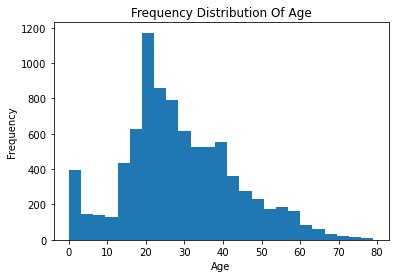

In [52]:
ax = plt.axes()
ax.hist(train.Age , bins = 25)
ax.set(xlabel="Age",ylabel="Frequency",title = "Frequency Distribution Of Age")
# Ages between 20 to 30 are likely to ve 

Text(0.5, 1.0, 'Total Missing Values')

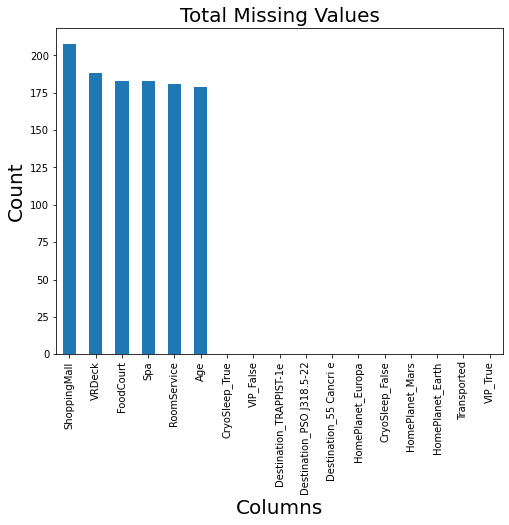

In [53]:
total = train.isnull().sum().sort_values(ascending = False)
total.plot(kind="bar",figsize=(8,6),fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

In [54]:
train.dropna(inplace = True) 
train.isna().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
dtype: int64

<AxesSubplot:xlabel='Age'>

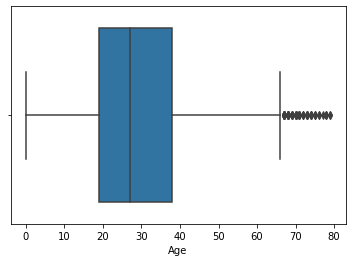

In [55]:
sns.boxplot(x = train['Age'])

<AxesSubplot:xlabel='FoodCourt'>

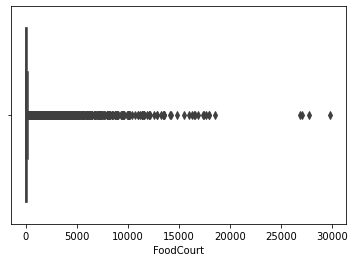

In [56]:
sns.boxplot(x = train['FoodCourt'])

<AxesSubplot:xlabel='VRDeck', ylabel='Transported'>

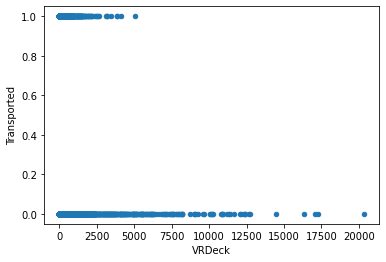

In [57]:
train.plot.scatter(x = "VRDeck", y = "Transported")

KeyboardInterrupt: 

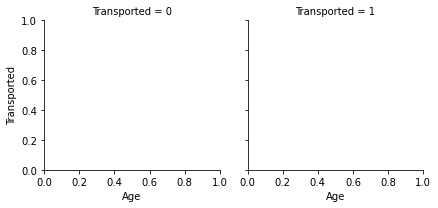

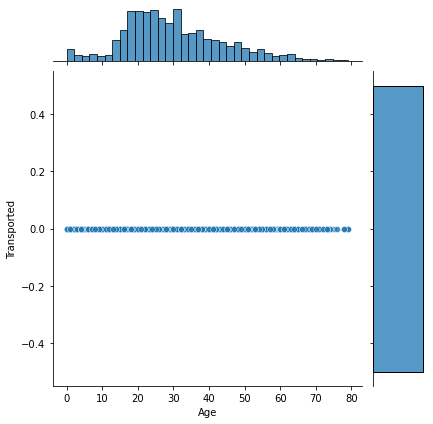

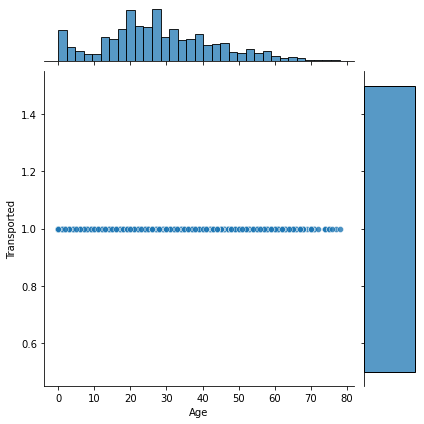

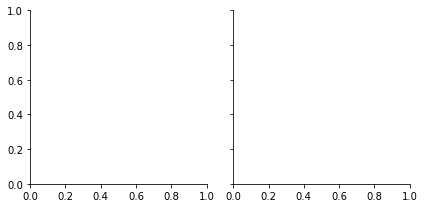

Error in callback <function flush_figures at 0x7f9d7359e4d0> (for post_execute):


KeyboardInterrupt: 

In [58]:
grid = sns.FacetGrid(train,col= "Transported")
grid.map(sns.jointplot, "Age","Transported",alpha=.8)
grid.add_legend()
grid = sns.FacetGrid(train,col= "Transported")
grid.map(sns.jointplot, "FoodCourt","Transported",alpha=.8)
grid.add_legend()
grid = sns.FacetGrid(train,col= "Transported")
grid.map(sns.jointplot, "RoomService","Transported",alpha=.8)
grid.add_legend()
grid = sns.FacetGrid(train,col= "Transported")
grid.map(sns.jointplot, "Spa","Transported",alpha=.8)
grid.add_legend()
grid = sns.FacetGrid(train,col= "Transported")
grid.map(sns.jointplot, "VRDeck","Transported",alpha=.8)
grid.add_legend()



In [59]:
min_max_scaler = MinMaxScaler(feature_range = (0,1)) 
train.iloc[:,:6] = min_max_scaler.fit_transform(train.iloc[:,0:6].values)

In [60]:
train_copy_to_be_trained = train.drop(['Transported'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(train_copy_to_be_trained,train['Transported'],test_size = 0.2, shuffle= True)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

6096
1524
6096
1524


<h2> Lets try out some ML algorithms </h2>

svm
random forest
xgboost
gradient boosting algoritmalarını bi dene bakalım.

In [63]:
def modelImplementation(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc_scores = accuracy_score(y_test,y_pred.round())
    f1_scores = f1_score(y_test,y_pred.round())
    conf_matrix = confusion_matrix(y_test,y_pred.round())
    return acc_scores,f1_scores,conf_matrix

In [64]:
cat_boost = ctb.CatBoostClassifier()
xg_reg = xgb.XGBRegressor(objective='reg:linear',colsample_bytree = 0.3,learning_rate = 0.1, max_depth=5 , alpha=10 , n_estimators = 10)
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
clf = SVC(kernel = "linear")
logisticRegr = LogisticRegression()

In [ ]:
list_of_models = []
list_of_models.append(cat_boost)
list_of_models.append(xg_reg)
list_of_models.append(rf)
list_of_models.append(clf)
list_of_models.append(logisticRegr)

accuracy_scores = [modelImplementation(model)[0] for model in list_of_models]
f1_scores = [modelImplementation(model)[1] for model in list_of_models]
conf_matrices = [modelImplementation(model)[2] for model in list_of_models]

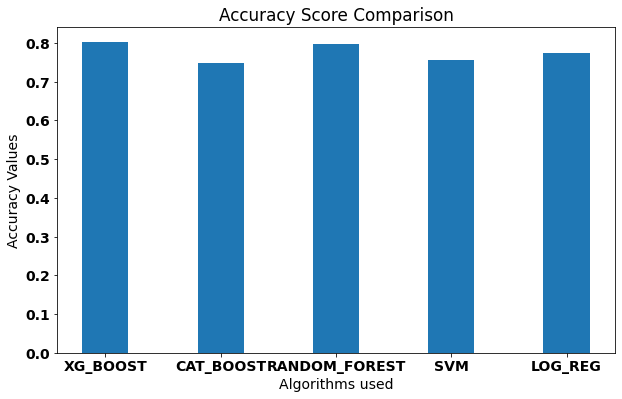

In [66]:
plt.figure(figsize=(10,6))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font',**font)
plt.bar(["XG_BOOST","CAT_BOOST","RANDOM_FOREST","SVM","LOG_REG"],accuracy_scores,width=0.4)
plt.xlabel("Algorithms used")
plt.ylabel("Accuracy Values")
plt.title("Accuracy Score Comparison")
plt.show()

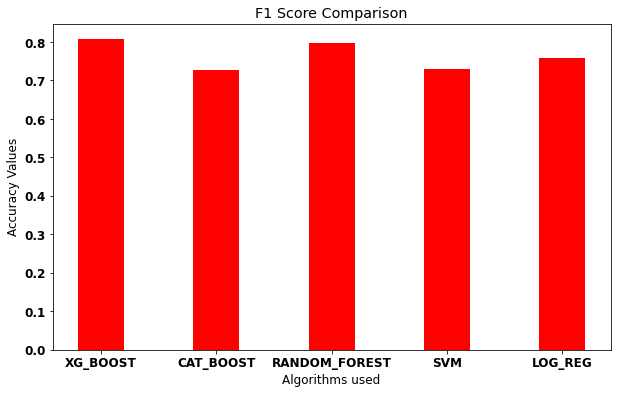

In [67]:
plt.figure(figsize=(10,6))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
algorithm_lists = ["XG_BOOST","CAT_BOOST","RANDOM_FOREST","SVM","LOG_REG"]

plt.rc('font',**font)
plt.bar(algorithm_lists,f1_scores,width=0.4,color='red')
plt.xlabel("Algorithms used")
plt.ylabel("Accuracy Values")
plt.title("F1 Score Comparison")
plt.show()